c:\Users\Vedant\miniconda3\envs\qiskit-ok\lib\site-packages\qutip\solver\solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


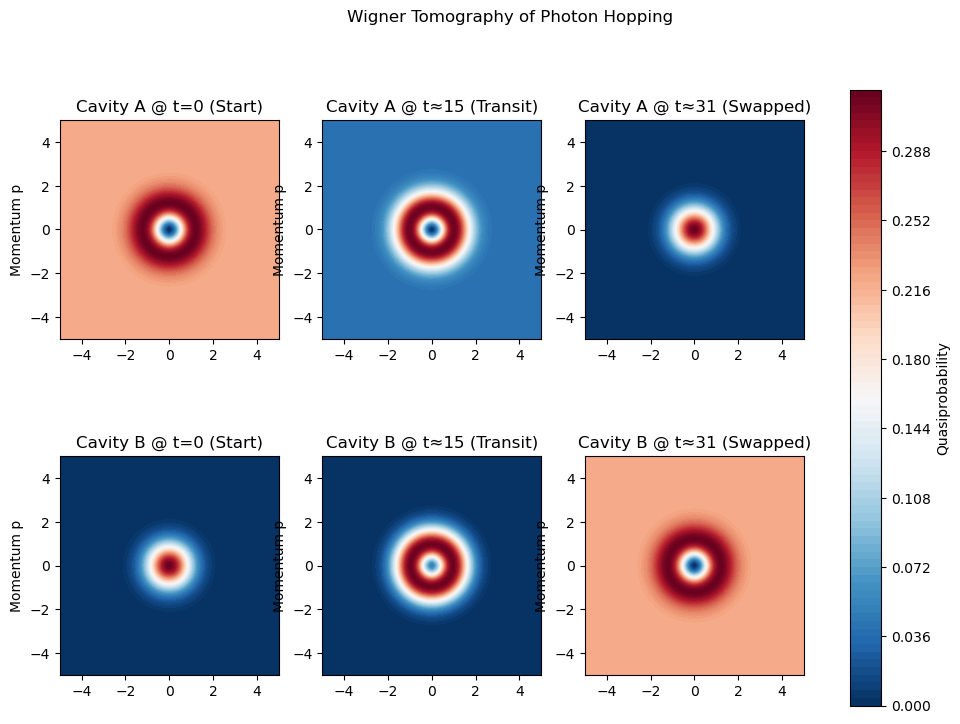

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
def build_coupled_cavities(N, w_a, w_b, g_hop):
    """
    Hamiltonian for two coupled cavities (No atoms).
    Hilber Space: tensor(Cavity_A, Cavity_B)
    """
    # 1. Define Operators
    # a acts on Cavity A (1st slot), b acts on Cavity B (2nd slot)
    a = tensor(destroy(N), qeye(N))
    b = tensor(qeye(N), destroy(N))
    
    # 2. Hamiltonian (from your notebook)
    # H = wa*a^dag*a + wb*b^dag*b + g(a^dag*b + a*b^dag)
    H_a = w_a * a.dag() * a
    H_b = w_b * b.dag() * b
    H_hop = g_hop * (a.dag() * b + a * b.dag())
    
    return H_a + H_b + H_hop

# --- Parameters ---
N = 10              # Hilbert space size
w_0 = 1.0           # Frequency
g_hop = 0.05        # Hopping strength (The 'g' in your notebook)

H = build_coupled_cavities(N, w_0, w_0, g_hop)

# --- Initial State ---
# One photon in Cavity A, Vacuum in Cavity B
# |1> (x) |0>
psi0 = tensor(basis(N, 1), basis(N, 0))
# --- 1. Re-Run Simulation to Get STATES ---
# (Assuming H and psi0 are defined from the previous step)
# We need to stop exactly when the swap is complete: t = pi / (2g)
t_swap = np.pi / (2 * 0.05) 
tlist_wigner = np.linspace(0, t_swap, 30) # 30 steps is enough

# Pass empty list [] to get state vectors
output_states = mesolve(H, psi0, tlist_wigner, [], [])

# --- 2. Select Time Indices ---
# Index 0 = Start
# Index 14 = Middle (approx)
# Index -1 = End
indices = [0, 14, -1]
time_labels = ["t=0 (Start)", "t≈15 (Transit)", "t≈31 (Swapped)"]

# --- 3. Plotting Setup ---
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
xvec = np.linspace(-5, 5, 100)

for i, idx in enumerate(indices):
    # Get the total system state (Cavity A (x) Cavity B)
    state = output_states.states[idx]
    
    # --- Analyze Cavity A ---
    # Trace out Cavity B (index 1) to look at A
    rho_A = state.ptrace(0)
    W_A = wigner(rho_A, xvec, xvec)
    
    # --- Analyze Cavity B ---
    # Trace out Cavity A (index 0) to look at B
    rho_B = state.ptrace(1)
    W_B = wigner(rho_B, xvec, xvec)
    
    # --- Plot A (Top Row) ---
    contA = axes[0, i].contourf(xvec, xvec, W_A, 100, cmap="RdBu_r")
    axes[0, i].set_title(f"Cavity A @ {time_labels[i]}")
    axes[0, i].set_ylabel("Momentum p")
    axes[0, i].set_aspect('equal')
    
    # --- Plot B (Bottom Row) ---
    contB = axes[1, i].contourf(xvec, xvec, W_B, 100, cmap="RdBu_r")
    axes[1, i].set_title(f"Cavity B @ {time_labels[i]}")
    axes[1, i].set_ylabel("Momentum p")
    axes[1, i].set_aspect('equal')

# Add a colorbar for reference
cbar = fig.colorbar(contA, ax=axes.ravel().tolist(), label="Quasiprobability")
plt.suptitle("Wigner Tomography of Photon Hopping")
plt.show()